In [12]:
import deepSI_jax
from deepSI_jax import get_nu_ny_and_auto_norm
import numpy as np

# Data generation
`deepSI-jax` uses IO data sequences gathered in separated `numpy` arrays with shapes $N$-by-$n_u$ and $N$-by-$n_y$, where $N$ is the length of the data sequence, $n_u$ is the input dimension, $n_y$ is the output dimension.

If the training (or test) data-set consists of multiple measurement records, create a list of `numpy` arrays as shown below.

In [13]:
# Generate or load data
np.random.seed(0)  # for reproducibility
U1 = np.random.randn(5000)  # Input sequence nr. 1
x = [0, 0]  # Initial state
ylist = []  # Output sequence
for uk in U1:
    ek = np.random.normal(loc=0, scale=0.05)
    ylist.append(x[0] + ek)  # Compute output
    x = x[0] / (1.2 + x[1]**2) + x[1] * 0.4, \
        x[1] / (1.2 + x[0]**2) + x[0] * 0.4 + uk  # Advance state
Y1 = np.array(ylist)  # Output sequence nr. 1

U2 = np.random.randn(5000)  # Input sequence nr. 2
x = [0.01, 0]  # Initial state
ylist = [] # Output sequence
for uk in U2:
    ek = np.random.normal(loc=0, scale=0.05)
    ylist.append(x[0] + ek)  # Compute output
    x = x[0] / (1.2 + x[1]**2) + x[1] * 0.4, \
        x[1] / (1.2 + x[0]**2) + x[0] * 0.4 + uk  # Advance state
Y2 = np.array(ylist)  # Output sequence nr. 2

# Split datasets
Y_train = [Y1, Y2[:4000]]  # just place multiple data sequences in a list
U_train = [U1, U2[:4000]]  # and apply the same for the input records as well

# if only a single data sequence is used, simply provide the input and output data as separate numpy arrays
Y_test = Y2[4000:]
U_test = U2[4000:]

# Hyperparameter selection and model creation
### ANN-SS models
The main objective of the `deepSI-jax` toolbox is to train discrete-time artificial neural network-based state-space (ANN-SS) models in the form of
\begin{align*}
\hat{x}_{k+1} &= f_\theta(\hat{x}_k, u_k),\\
\hat{y}_{k} &= h_\theta(\hat{x}_k, u_k),
\end{align*}
where $k$ is the time index, $\hat{x}_k$ is the model state, $u_k$ is the control input, $\hat{y}_k$ is the model output, furthermore $f$ and $h$ are implemented as feedforward ANNs with $\theta$ containing their tunable parameters (weights and biases). In some special cases, an encoder network is also part of the model structure, but more on that later. This example script will show the basics of creating and training ANN-SS models with the `deepSI-jax` toolbox.

### IO dimensions and data normalization
The input and output dimensions of the data-generating system, moreover the mean and standard deviation values (which is required for data normalization) are computed automatically by calling the `get_nu_ny_auto_norm` function. The `norm` object is a dictionary with entries `y_mean`, `y_std`, etc., which will later used for model creation.

In [14]:
# hyperparameters and data normalization
nu, ny, norm = get_nu_ny_and_auto_norm(Y_train, U_train)
print(norm)

{'y_mean': array([-0.03780075]), 'y_std': array([0.76891903]), 'u_mean': array([-0.01014596]), 'u_std': array([0.99269028])}


### Selecting the ANN structures
The ANN structures can be defined by providing different dictionaries that contain the following entries:
- `hidden_layers` : Number of hidden layers in the ANN.
- `nodes_per_layer` : Number of nodes (neurons) of the hidden layers.
- `activation` : Activation function of the ANN in a string form. Currently, the supported inputs are: `None` for linear activation, `"relu"` for rectified linear, `"tanh"` for hyperbolic tangent, `"sigmoid"` for the logistic function, and finally the `"swish"` activation.
- `feedthrough` : only interpreted for the output map $h_\theta$. If `feedthrough = True`, then $\hat{y}_k = h_\theta(\hat{x}_k, u_k)$, otherwise the model output will not depend on the input value, as $\hat{y}_k = h_\theta(\hat{x}_k)$.

Each of these settings is optional, the default values are 2 hidden layers with 16 nodes per layer and the tanh activation function. For the output map, the default is `feedthrough = True`.

In [15]:
f_dict = dict(hidden_layers=2, nodes_per_layer=32, activation='tanh')
h_dict = dict(feedthrough=False)  # hidden_layers=2, nodes_per_layer=16, activation='tanh' by default

### Other parameters
The last parameters that need to be selected before creating the model are:
- `nx` : The dimension of the model state.
- `seed` (optional): Seed number for initialization. Useful for reproducibility and selecting initial parameters that are closer to the global minima to prevent getting stuck at a local optimum.

Further parameters are `use_encoder` and `encoder_lag`, but we will introduce them in the next example script. The toolbox mainly builds in the results of subspace encoder-based ANN-SS identification (i.e., SUBNET, more on them: https://www.sciencedirect.com/science/article/pii/S0005109823003710), hence models can be initialized with the `deepSI_jax.SUBNET` class, as shown below.


In [16]:
nx = 3
model = deepSI_jax.SUBNET(nx=nx, ny=ny, nu=nu, norm=norm, f_args=f_dict, h_args=h_dict, use_encoder=False, seed=3)

# Loss function and optimization algorithm settings
### Optional regularization terms
Regularization terms can be added to the cost function by calling the `set_loss_fun` method of the model. It is possible to set the coefficients of $\ell_1$ and $\ell_2$ regularization on the model parameters $\theta$, $\ell_2$ regularization of the initial states $\hat{x}_0$ (since they are co-estimated with $\theta$ if no encoder function is used).

Further (optional) inputs are:
- `output_loss` : By default this is the root-mean-squared error of the simulated output, but custom function can also be provided (e.g., normalized RMSE) in the form of `loss=output_loss(Yhat,Y)`.
- `group_lasso_reg` and `group_lasso_fcn` relate to group-lasso regularization for automatic model order selection and can be provided here. #TODO: group lasso function on x should be included in the model
- `zero_coeff` : Model coefficients that are smaller in absolute value than `zero_coeff` are set to zero. Mostly useful when $\ell_1$ or group-lasso regularization is applied.
- `xsat` : State values are saturated at this value during training to prevent numerical issues. By default, this is not applied.
- Other options are related to the truncated prediction loss, but more on them later.

In [17]:
model.set_loss_fun(l2_reg=1e-4, l1_reg=0., l2_reg_x0=1e-3)

### Optimization algorithm settings
Lastly, the settings of the optimization algorithms need to be given by calling the `optimization` method of the model. The most important settings are the Adam and L-BFGS-B epochs, but specific parameters can be also set for each optimization algorithm and parameter bounds (box constraints) can be also defined.

In [18]:
model.optimization(adam_epochs=200, lbfgs_epochs=200, iprint=-1)  # only to run fast
# model.optimization(adam_epochs=1000, lbfgs_epochs=5000)  # uncomment this for better results (~2.5-min training)

# Model training
After setting up the model and optimization parameters, the training can be started by calling the `fit` method.

In [19]:
# Train model on data
model.fit(Y_train, U_train)

L-BFGS-B done in 170 iterations.


In [20]:
t0 = model.t_solve
print(f"Elapsed time: {t0} s")

Elapsed time: 8.433675765991211 s


# Evaluating the trained models on new (test) data
To simulate the model using new data, simply call `model.simulate`. To do so, it is necessary to provide an initial state value. If the model does not contain an encoder network, an optimization-based initial state estimation can be applied by running the `learn_x0` method of the model.

In [21]:
n = 20  # state initialization window
x0_test = model.learn_x0(U_test[:n], Y_test[:n], RTS_epochs=10, LBFGS_refinement=True, verbosity=False)
Yhat_test, _ = model.simulate(x0_test, U_test)

For model evaluations, the `deepSI_jax.utils` file contains various error metrics.

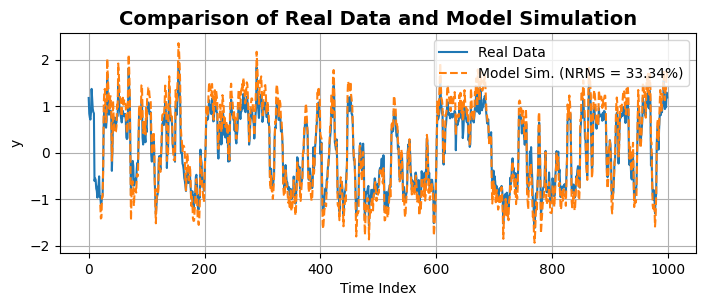

In [22]:
from deepSI_jax.utils import NRMS_error
# only evaluate the part that was not used for estimating x0
nrmse = NRMS_error(Y_test[n:], Yhat_test[n:, 0])

sim_idx = np.arange(U_test.shape[0])
# Visualize simulation of the model
from matplotlib import pyplot as plt
plt.figure(figsize=(7,3))
plt.plot(sim_idx, Y_test, label='Real Data')
plt.plot(sim_idx[n:], Yhat_test[n:, 0], label=f'Model Sim. (NRMS = {nrmse:.2%})', linestyle='--')
plt.title('Comparison of Real Data and Model Simulation', fontsize=14, fontweight='bold')
plt.legend(); plt.xlabel('Time Index'); plt.ylabel('y'); plt.grid(); plt.tight_layout(pad=0.5)
plt.show()